In [1]:
#imprt Libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt 
import scipy.stats as st 
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [2]:
#import Data
data_train=pd.read_csv('../../data/Car_train-data.csv')

In [3]:
data_train.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [4]:
# data Cleaning function
def Data_clean(data_train):

    data_train = data_train.iloc[:, 1:]

    # selection of important columns
    data_train_c = data_train.iloc[:, [0,1,2, 3, 4, 5, 7, 8, 9, 10]]
    print(data_train_c.columns)

    # firstly we need to Clean the data for This Dataframe
    data_train_c.replace({' ': np.nan, 'null': np.nan}, inplace=True)
    data_train_c = data_train_c.dropna()

    # Here you can see 'null bhp' occur so it's replace by np.nan and then drop this raw
    data_train_c.replace(
        {'null bhp': np.nan, 'null km/kg': np.nan, 'null CC': np.nan}, inplace=True)
    data_train_c = data_train_c.dropna()

    # remove extenation  km/kg ,bhp, CC from below column and convert string into float Value
    l1 = ['Mileage', 'Engine', 'Power']
    for i in l1:
        data_train_c[i] = data_train_c[i].str.split(" ").apply(lambda x: x[0])
        data_train_c[i] = data_train_c[i].str.strip()
        data_train_c[i] = data_train_c[i].astype(float)

    # Fule_Type column is Categorical data so we need to convert into numeric order for Better Price prediction
    data_train_c.Fuel_Type.replace(
        {'Petrol': 1, 'CNG': 3, 'Diesel': 2, 'LPG': 4}, inplace=True)

    # Above thing apply in Transmission column
    data_train_c.Transmission.replace(
        {'Manual': 1, 'Automatic': 2}, inplace=True)

    ''' Here 'Kilometers_Driven' in High value data so we need to convert high value to lower value
    therfore we easily compare with  price value '''
    data_train_c['KM_Drlog_form'] = np.log(data_train_c['Kilometers_Driven'])

    data_train_c1 = data_train_c.copy()

    return data_train_c1

In [5]:
Mulit_df=Data_clean(data_train)

Index(['Name', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Mileage', 'Engine', 'Power', 'Seats'],
      dtype='object')


In [75]:
Mulit_df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats,KM_Drlog_form
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,3,1,26.60,998.0,58.16,5.0,11.184421
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,2,1,19.67,1582.0,126.20,5.0,10.621327
2,Honda Jazz V,Chennai,2011,46000,1,1,18.20,1199.0,88.70,5.0,10.736397
3,Maruti Ertiga VDI,Chennai,2012,87000,2,1,20.77,1248.0,88.76,7.0,11.373663
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,2,2,15.20,1968.0,140.80,5.0,10.613246


In [6]:
Mulit_df['Company']=Mulit_df['Name'].str.split(" ").apply(lambda x: str(x[0])).astype('str')

In [7]:
Mulit_df['Company']=Mulit_df['Company'].astype(str)
Mulit_df

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats,KM_Drlog_form,Company
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,3,1,26.60,998.0,58.16,5.0,11.184421,Maruti
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,2,1,19.67,1582.0,126.20,5.0,10.621327,Hyundai
2,Honda Jazz V,Chennai,2011,46000,1,1,18.20,1199.0,88.70,5.0,10.736397,Honda
3,Maruti Ertiga VDI,Chennai,2012,87000,2,1,20.77,1248.0,88.76,7.0,11.373663,Maruti
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,2,2,15.20,1968.0,140.80,5.0,10.613246,Audi
...,...,...,...,...,...,...,...,...,...,...,...,...
6014,Maruti Swift VDI,Delhi,2014,27365,2,1,28.40,1248.0,74.00,5.0,10.217020,Maruti
6015,Hyundai Xcent 1.1 CRDi S,Jaipur,2015,100000,2,1,24.40,1120.0,71.00,5.0,11.512925,Hyundai
6016,Mahindra Xylo D4 BSIV,Jaipur,2012,55000,2,1,14.00,2498.0,112.00,8.0,10.915088,Mahindra
6017,Maruti Wagon R VXI,Kolkata,2013,46000,1,1,18.90,998.0,67.10,5.0,10.736397,Maruti


In [8]:
Mulit_df['Price']=data_train['Price']
Multi_df=Mulit_df.dropna()

<AxesSubplot:xlabel='Price', ylabel='Density'>

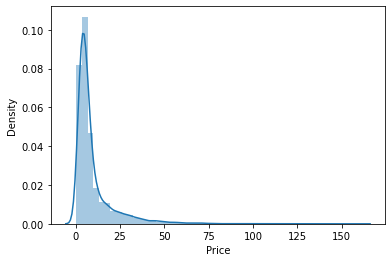

In [9]:
sns.distplot(Mulit_df['Price'])

In [10]:
Mulit_df['Log_Price']=np.log(Mulit_df['Price']+1)


In [11]:
Mulit_df

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats,KM_Drlog_form,Company,Price,Log_Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,3,1,26.60,998.0,58.16,5.0,11.184421,Maruti,1.75,1.011601
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,2,1,19.67,1582.0,126.20,5.0,10.621327,Hyundai,12.50,2.602690
2,Honda Jazz V,Chennai,2011,46000,1,1,18.20,1199.0,88.70,5.0,10.736397,Honda,4.50,1.704748
3,Maruti Ertiga VDI,Chennai,2012,87000,2,1,20.77,1248.0,88.76,7.0,11.373663,Maruti,6.00,1.945910
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,2,2,15.20,1968.0,140.80,5.0,10.613246,Audi,17.74,2.930660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,Maruti Swift VDI,Delhi,2014,27365,2,1,28.40,1248.0,74.00,5.0,10.217020,Maruti,4.75,1.749200
6015,Hyundai Xcent 1.1 CRDi S,Jaipur,2015,100000,2,1,24.40,1120.0,71.00,5.0,11.512925,Hyundai,4.00,1.609438
6016,Mahindra Xylo D4 BSIV,Jaipur,2012,55000,2,1,14.00,2498.0,112.00,8.0,10.915088,Mahindra,2.90,1.360977
6017,Maruti Wagon R VXI,Kolkata,2013,46000,1,1,18.90,998.0,67.10,5.0,10.736397,Maruti,2.65,1.294727


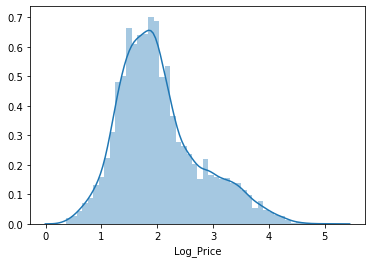

In [12]:
sns.distplot(Mulit_df['Log_Price'])

In [12]:
Mulit_df['Log_Power']=np.log(Mulit_df['Power']+1)

In [13]:
Mulit_df

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats,KM_Drlog_form,Company,Price,Log_Price,Log_Power
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,3,1,26.60,998.0,58.16,5.0,11.184421,Maruti,1.75,1.011601,4.080246
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,2,1,19.67,1582.0,126.20,5.0,10.621327,Hyundai,12.50,2.602690,4.845761
2,Honda Jazz V,Chennai,2011,46000,1,1,18.20,1199.0,88.70,5.0,10.736397,Honda,4.50,1.704748,4.496471
3,Maruti Ertiga VDI,Chennai,2012,87000,2,1,20.77,1248.0,88.76,7.0,11.373663,Maruti,6.00,1.945910,4.497139
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,2,2,15.20,1968.0,140.80,5.0,10.613246,Audi,17.74,2.930660,4.954418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,Maruti Swift VDI,Delhi,2014,27365,2,1,28.40,1248.0,74.00,5.0,10.217020,Maruti,4.75,1.749200,4.317488
6015,Hyundai Xcent 1.1 CRDi S,Jaipur,2015,100000,2,1,24.40,1120.0,71.00,5.0,11.512925,Hyundai,4.00,1.609438,4.276666
6016,Mahindra Xylo D4 BSIV,Jaipur,2012,55000,2,1,14.00,2498.0,112.00,8.0,10.915088,Mahindra,2.90,1.360977,4.727388
6017,Maruti Wagon R VXI,Kolkata,2013,46000,1,1,18.90,998.0,67.10,5.0,10.736397,Maruti,2.65,1.294727,4.220977


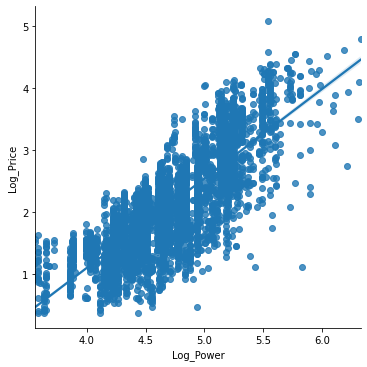

In [14]:
sns.lmplot('Log_Power','Log_Price',data=Mulit_df)

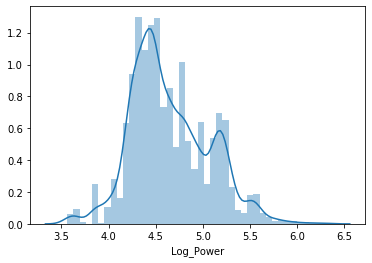

In [16]:
sns.distplot(Mulit_df['Log_Power'])

<AxesSubplot:xlabel='Year', ylabel='Density'>

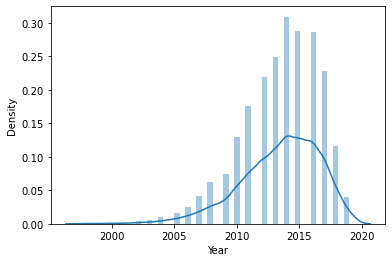

In [15]:
sns.distplot(Mulit_df['Year'])

In [16]:
Mulit_df['Log_Year']=np.log(Mulit_df['Year']+1)

In [17]:
Mulit_df

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats,KM_Drlog_form,Company,Price,Log_Price,Log_Power,Log_Year
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,3,1,26.60,998.0,58.16,5.0,11.184421,Maruti,1.75,1.011601,4.080246,7.606387
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,2,1,19.67,1582.0,126.20,5.0,10.621327,Hyundai,12.50,2.602690,4.845761,7.608871
2,Honda Jazz V,Chennai,2011,46000,1,1,18.20,1199.0,88.70,5.0,10.736397,Honda,4.50,1.704748,4.496471,7.606885
3,Maruti Ertiga VDI,Chennai,2012,87000,2,1,20.77,1248.0,88.76,7.0,11.373663,Maruti,6.00,1.945910,4.497139,7.607381
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,2,2,15.20,1968.0,140.80,5.0,10.613246,Audi,17.74,2.930660,4.954418,7.607878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,Maruti Swift VDI,Delhi,2014,27365,2,1,28.40,1248.0,74.00,5.0,10.217020,Maruti,4.75,1.749200,4.317488,7.608374
6015,Hyundai Xcent 1.1 CRDi S,Jaipur,2015,100000,2,1,24.40,1120.0,71.00,5.0,11.512925,Hyundai,4.00,1.609438,4.276666,7.608871
6016,Mahindra Xylo D4 BSIV,Jaipur,2012,55000,2,1,14.00,2498.0,112.00,8.0,10.915088,Mahindra,2.90,1.360977,4.727388,7.607381
6017,Maruti Wagon R VXI,Kolkata,2013,46000,1,1,18.90,998.0,67.10,5.0,10.736397,Maruti,2.65,1.294727,4.220977,7.607878


<AxesSubplot:xlabel='Log_Year', ylabel='Density'>

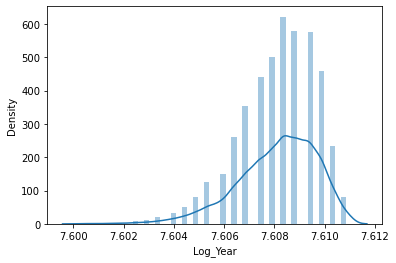

In [18]:
sns.distplot(Mulit_df['Log_Year'])

In [19]:
model=smf.ols('Log_Price~Log_Power+Log_Year',data=Mulit_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Log_Price   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                 1.344e+04
Date:                Tue, 07 Sep 2021   Prob (F-statistic):               0.00
Time:                        19:11:46   Log-Likelihood:                -1538.4
No. Observations:                5872   AIC:                             3083.
Df Residuals:                    5869   BIC:                             3103.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1536.2476     19.881    -77.272      0.000   -1575.222   -1497.273
Log_Power      1.4105      0.010    141.615      0.000       1.391       1.430
Log_Year     201.3279      2.613     77.038      0.000     196.205     206.451
==============================================================================
Omnibus:                      323.341   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1276.426
Skew:                           0.082   Prob(JB):                    6.72e-278
Kurtosis:                       5.278   Cond. No.                     4.38e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
Mulit_df['pre_price']=np.exp(model.predict())



In [21]:
Mulit_df

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats,KM_Drlog_form,Company,Price,Log_Price,Log_Power,Log_Year,pre_price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,3,1,26.60,998.0,58.16,5.0,11.184421,Maruti,1.75,1.011601,4.080246,7.606387,2.424316
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,2,1,19.67,1582.0,126.20,5.0,10.621327,Hyundai,12.50,2.602690,4.845761,7.608871,11.766378
2,Honda Jazz V,Chennai,2011,46000,1,1,18.20,1199.0,88.70,5.0,10.736397,Honda,4.50,1.704748,4.496471,7.606885,4.819737
3,Maruti Ertiga VDI,Chennai,2012,87000,2,1,20.77,1248.0,88.76,7.0,11.373663,Maruti,6.00,1.945910,4.497139,7.607381,5.331865
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,2,2,15.20,1968.0,140.80,5.0,10.613246,Audi,17.74,2.930660,4.954418,7.607878,11.230986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,Maruti Swift VDI,Delhi,2014,27365,2,1,28.40,1248.0,74.00,5.0,10.217020,Maruti,4.75,1.749200,4.317488,7.608374,5.054269
6015,Hyundai Xcent 1.1 CRDi S,Jaipur,2015,100000,2,1,24.40,1120.0,71.00,5.0,11.512925,Hyundai,4.00,1.609438,4.276666,7.608871,5.272707
6016,Mahindra Xylo D4 BSIV,Jaipur,2012,55000,2,1,14.00,2498.0,112.00,8.0,10.915088,Mahindra,2.90,1.360977,4.727388,7.607381,7.377717
6017,Maruti Wagon R VXI,Kolkata,2013,46000,1,1,18.90,998.0,67.10,5.0,10.736397,Maruti,2.65,1.294727,4.220977,7.607878,3.991496


In [24]:
np.var(model.predict())/np.var(Mulit_df['Log_Price'])

0.8208141622619745

In [25]:
Mulit_df

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats,KM_Drlog_form,Company,Price,Log_Price,Log_Power,Log_Year,pre_price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,3,1,26.60,998.0,58.16,5.0,11.184421,Maruti,1.75,1.011601,4.080246,7.606387,2.424316
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,2,1,19.67,1582.0,126.20,5.0,10.621327,Hyundai,12.50,2.602690,4.845761,7.608871,11.766378
2,Honda Jazz V,Chennai,2011,46000,1,1,18.20,1199.0,88.70,5.0,10.736397,Honda,4.50,1.704748,4.496471,7.606885,4.819737
3,Maruti Ertiga VDI,Chennai,2012,87000,2,1,20.77,1248.0,88.76,7.0,11.373663,Maruti,6.00,1.945910,4.497139,7.607381,5.331865
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,2,2,15.20,1968.0,140.80,5.0,10.613246,Audi,17.74,2.930660,4.954418,7.607878,11.230986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,Maruti Swift VDI,Delhi,2014,27365,2,1,28.40,1248.0,74.00,5.0,10.217020,Maruti,4.75,1.749200,4.317488,7.608374,5.054269
6015,Hyundai Xcent 1.1 CRDi S,Jaipur,2015,100000,2,1,24.40,1120.0,71.00,5.0,11.512925,Hyundai,4.00,1.609438,4.276666,7.608871,5.272707
6016,Mahindra Xylo D4 BSIV,Jaipur,2012,55000,2,1,14.00,2498.0,112.00,8.0,10.915088,Mahindra,2.90,1.360977,4.727388,7.607381,7.377717
6017,Maruti Wagon R VXI,Kolkata,2013,46000,1,1,18.90,998.0,67.10,5.0,10.736397,Maruti,2.65,1.294727,4.220977,7.607878,3.991496


In [22]:
Time= np.linspace(0, 1000, 10)

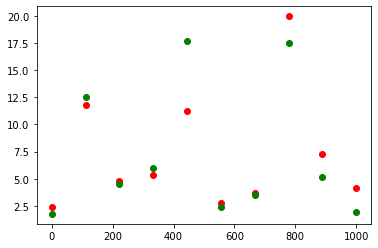

In [23]:
plt.scatter(Time,Mulit_df['pre_price'][:10],color='r')
plt.scatter(Time,Mulit_df['Price'][:10],color='g')

In [25]:
Mulit_df['resd']=Mulit_df['Price']-Mulit_df['pre_price']

In [26]:
Mulit_df

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Mileage,Engine,Power,Seats,KM_Drlog_form,Company,Price,Log_Price,Log_Power,Log_Year,pre_price,resd
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,3,1,26.60,998.0,58.16,5.0,11.184421,Maruti,1.75,1.011601,4.080246,7.606387,2.424316,-0.674316
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,2,1,19.67,1582.0,126.20,5.0,10.621327,Hyundai,12.50,2.602690,4.845761,7.608871,11.766378,0.733622
2,Honda Jazz V,Chennai,2011,46000,1,1,18.20,1199.0,88.70,5.0,10.736397,Honda,4.50,1.704748,4.496471,7.606885,4.819737,-0.319737
3,Maruti Ertiga VDI,Chennai,2012,87000,2,1,20.77,1248.0,88.76,7.0,11.373663,Maruti,6.00,1.945910,4.497139,7.607381,5.331865,0.668135
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,2,2,15.20,1968.0,140.80,5.0,10.613246,Audi,17.74,2.930660,4.954418,7.607878,11.230986,6.509014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,Maruti Swift VDI,Delhi,2014,27365,2,1,28.40,1248.0,74.00,5.0,10.217020,Maruti,4.75,1.749200,4.317488,7.608374,5.054269,-0.304269
6015,Hyundai Xcent 1.1 CRDi S,Jaipur,2015,100000,2,1,24.40,1120.0,71.00,5.0,11.512925,Hyundai,4.00,1.609438,4.276666,7.608871,5.272707,-1.272707
6016,Mahindra Xylo D4 BSIV,Jaipur,2012,55000,2,1,14.00,2498.0,112.00,8.0,10.915088,Mahindra,2.90,1.360977,4.727388,7.607381,7.377717,-4.477717
6017,Maruti Wagon R VXI,Kolkata,2013,46000,1,1,18.90,998.0,67.10,5.0,10.736397,Maruti,2.65,1.294727,4.220977,7.607878,3.991496,-1.341496


<AxesSubplot:xlabel='resd', ylabel='Density'>

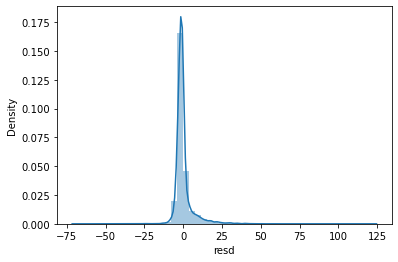

In [27]:
sns.distplot(Mulit_df['resd'])

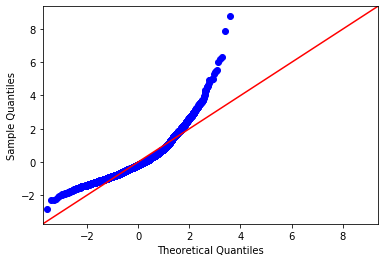

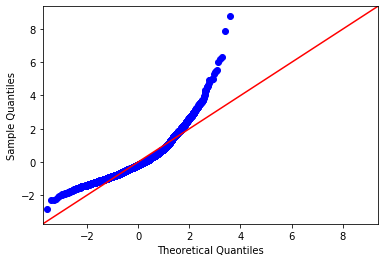

In [32]:
sm.qqplot(np.exp(model.resid),fit=True,line='45')

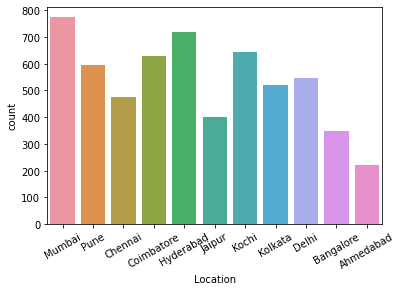

In [39]:
sns.countplot(Mulit_df['Location']).set_xticklabels(Mulit_df['Location'].unique(),rotation=30)
plt.show()

In [34]:
%matplotlib qt 

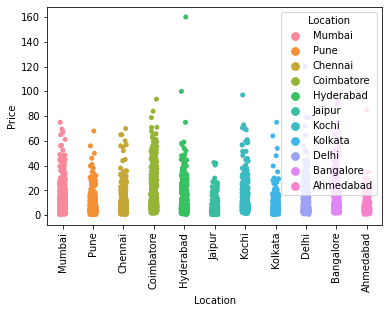

In [40]:
sns.stripplot(Mulit_df['Location'],Multi_df['Price'],hue=Mulit_df['Location'],orient='v').set_xticklabels(Mulit_df['Location'].unique(),rotation=90)
plt.show()

In [41]:
np.var(Mulit_df.groupby('Location')['Price'].mean())

8.1075554421615

In [42]:
Mulit_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5872 entries, 0 to 6018
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               5872 non-null   object 
 1   Location           5872 non-null   object 
 2   Year               5872 non-null   int64  
 3   Kilometers_Driven  5872 non-null   int64  
 4   Fuel_Type          5872 non-null   int64  
 5   Transmission       5872 non-null   int64  
 6   Mileage            5872 non-null   float64
 7   Engine             5872 non-null   float64
 8   Power              5872 non-null   float64
 9   Seats              5872 non-null   float64
 10  KM_Drlog_form      5872 non-null   float64
 11  Company            5872 non-null   object 
 12  Price              5872 non-null   float64
 13  Log_Price          5872 non-null   float64
 14  Log_Power          5872 non-null   float64
 15  Log_Year           5872 non-null   float64
 16  pre_price          5872 

In [43]:
ind_city=Mulit_df.groupby('Location')['Log_Price'].mean().to_frame().reset_index()


In [44]:
ind_city

,Location,Log_Price
0,Ahmedabad,2.018673
1,Bangalore,2.327184
2,Chennai,1.870881
3,Coimbatore,2.458940
4,Delhi,2.060046
5,Hyderabad,2.063259
6,Jaipur,1.705070
7,Kochi,2.225282
8,Kolkata,1.678850
9,Mumbai,2.056282


In [45]:
var_u=ind_city.var()

In [46]:
var_e=Mulit_df['Log_Price'].var()

In [47]:
var_e

0.5519001893223563

In [48]:
var_part_cof= var_u/(var_e+var_u)

In [49]:
var_part_cof

Log_Price    0.101671
dtype: float64

In [50]:
ind_company=Mulit_df.groupby('Company')['Log_Price'].median().sort_values().to_frame().reset_index()
ind_company

,Company,Log_Price
0,Ambassador,0.854415
1,Chevrolet,1.252763
2,Fiat,1.280934
3,Tata,1.360977
4,Datsun,1.410987
5,Maruti,1.642873
6,Nissan,1.704748
7,Hyundai,1.753538
8,Volkswagen,1.769849
9,Honda,1.783391


In [51]:

# Company_sort=Mulit_df.sort_values(['Log_Price'])
# Company_sort=Company_sort.groupby('Company')
# Company_sort=pd.concat(map(lambda x: x[1], Company_sort))

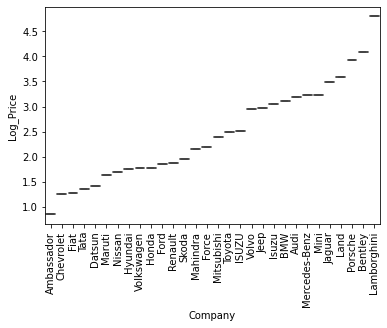

In [52]:

plt.figure()
sns.boxplot('Company','Log_Price',data=ind_company).set_xticklabels(ind_company['Company'],rotation=90)
plt.show()

In [53]:
ind_company_co=Mulit_df.groupby('Company')['Log_Price'].count().sort_values().to_frame().reset_index()
ind_company_co

,Company,Log_Price
0,Ambassador,1
1,Lamborghini,1
2,Isuzu,1
3,Bentley,1
4,ISUZU,2
5,Force,3
6,Datsun,13
7,Jeep,15
8,Porsche,16
9,Volvo,21


[Text(0, 0, 'Ambassador'),
 Text(1, 0, 'Lamborghini'),
 Text(2, 0, 'Isuzu'),
 Text(3, 0, 'Bentley'),
 Text(4, 0, 'ISUZU'),
 Text(5, 0, 'Force'),
 Text(6, 0, 'Datsun'),
 Text(7, 0, 'Jeep'),
 Text(8, 0, 'Porsche'),
 Text(9, 0, 'Volvo'),
 Text(10, 0, 'Fiat'),
 Text(11, 0, 'Mini'),
 Text(12, 0, 'Mitsubishi'),
 Text(13, 0, 'Jaguar'),
 Text(14, 0, 'Land'),
 Text(15, 0, 'Nissan'),
 Text(16, 0, 'Chevrolet'),
 Text(17, 0, 'Renault'),
 Text(18, 0, 'Skoda'),
 Text(19, 0, 'Tata'),
 Text(20, 0, 'Audi'),
 Text(21, 0, 'BMW'),
 Text(22, 0, 'Mahindra'),
 Text(23, 0, 'Ford'),
 Text(24, 0, 'Volkswagen'),
 Text(25, 0, 'Mercedes-Benz'),
 Text(26, 0, 'Toyota'),
 Text(27, 0, 'Honda'),
 Text(28, 0, 'Hyundai'),
 Text(29, 0, 'Maruti')]

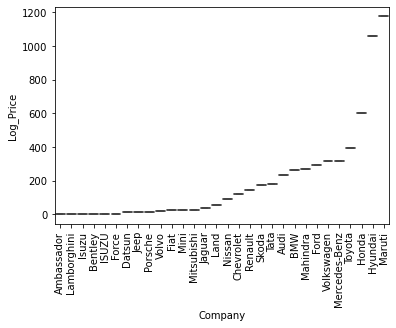

In [54]:

plt.figure()
sns.boxplot('Company','Log_Price',data=ind_company_co).set_xticklabels(ind_company_co['Company'],rotation=90)


In [55]:
var_u=ind_company.var()

In [56]:
var_u

Log_Price    0.935743
dtype: float64

In [57]:
var_e=Mulit_df['Log_Price'].var()

In [58]:
var_e

0.5519001893223563

In [63]:
var_part_cof= var_u/(var_e+var_u)

In [64]:
var_part_cof

Log_Price    0.62901
dtype: float64

In [65]:
Mulit_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5872 entries, 0 to 6018
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               5872 non-null   object 
 1   Location           5872 non-null   object 
 2   Year               5872 non-null   int64  
 3   Kilometers_Driven  5872 non-null   int64  
 4   Fuel_Type          5872 non-null   int64  
 5   Transmission       5872 non-null   int64  
 6   Mileage            5872 non-null   float64
 7   Engine             5872 non-null   float64
 8   Power              5872 non-null   float64
 9   Seats              5872 non-null   float64
 10  KM_Drlog_form      5872 non-null   float64
 11  Company            5872 non-null   object 
 12  Price              5872 non-null   float64
 13  Log_Price          5872 non-null   float64
 14  Log_Power          5872 non-null   float64
 15  Log_Year           5872 non-null   float64
 16  pre_price          5872 

##  Model 

In [66]:
model=smf.ols('Log_Price~(Log_Power+Log_Year)+C(Company)',data=Mulit_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Log_Price   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     1783.
Date:                Tue, 07 Sep 2021   Prob (F-statistic):               0.00
Time:                        19:31:24   Log-Likelihood:                 306.62
No. Observations:                5872   AIC:                            -549.2
Df Residuals:                    5840   BIC:                            -335.5
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                   -1552.5401     14.867   -104.428      0.000   -1581.685   -1523.395
C(Company)[T.Audi]             -0.2924      0.232     -1.261      0.207      -0.747       0.162
C(Company)[T.BMW]              -0.3767      0.232     -1.625      0.104      -0.831       0.078
C(Company)[T.Bentley]           0.3874      0.327      1.183      0.237      -0.254       1.029
C(Company)[T.Chevrolet]        -1.2219      0.232     -5.276      0.000      -1.676      -0.768
C(Company)[T.Datsun]           -1.3062      0.239     -5.456      0.000      -1.775      -0.837
C(Company)[T.Fiat]             -1.1906      0.236     -5.053      0.000      -1.653      -0.729
C(Company)[T.Force]            -0.9108      0.267     -3.417      0.001      -1.433      -0.388
C(Company)[T.Ford]             -0.9492      0.231     -4.107      0.000      -1.402      -0.496
C(Company)[T.Honda]            -1.1052      0.231     -4.784      0.000      -1.558      -0.652
C(Company)[T.Hyundai]          -1.0317      0.231     -4.469      0.000      -1.484      -0.579
C(Company)[T.ISUZU]            -1.0323      0.283     -3.651      0.000      -1.587      -0.478
C(Company)[T.Isuzu]            -0.7014      0.326     -2.149      0.032      -1.341      -0.061
C(Company)[T.Jaguar]           -0.1749      0.234     -0.746      0.456      -0.634       0.285
C(Company)[T.Jeep]             -0.8019      0.239     -3.357      0.001      -1.270      -0.334
C(Company)[T.Lamborghini]       0.5681      0.327      1.735      0.083      -0.074       1.210
C(Company)[T.Land]              0.0399      0.233      0.171      0.864      -0.417       0.497
C(Company)[T.Mahindra]         -0.9362      0.231     -4.047      0.000      -1.390      -0.483
C(Company)[T.Maruti]           -0.9565      0.231     -4.145      0.000      -1.409      -0.504
C(Company)[T.Mercedes-Benz]    -0.2941      0.232     -1.269      0.204      -0.748       0.160
C(Company)[T.Mini]             -0.0601      0.235     -0.255      0.798      -0.522       0.401
C(Company)[T.Mitsubishi]       -0.5977      0.235     -2.542      0.011      -1.059      -0.137
C(Company)[T.Nissan]           -1.0031      0.232     -4.324      0.000      -1.458      -0.548
C(Company)[T.Porsche]          -0.2291      0.239     -0.959      0.338      -0.698       0.239
C(Company)[T.Renault]          -0.9893      0.232     -4.272      0.000      -1.443      -0.535
C(Company)[T.Skoda]            -0.9388      0.232     -4.054      0.000      -1.393      -0.485
C(Company)[T.Tata]             -1.2110      0.231     -5.236      0.000      -1.664      -0.758
C(Company)[T.Toyota]           -0.6311      0.231     -2.729      0.006      -1.084      -0.178
C(Company)[T.Volkswagen]       -1.0190      0.231     -4.409      0.000      -1.472      -0.566
C(Company)[

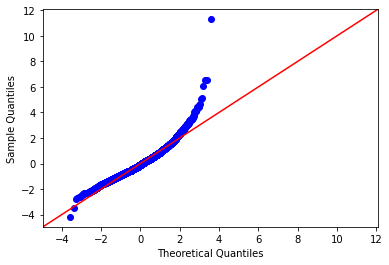

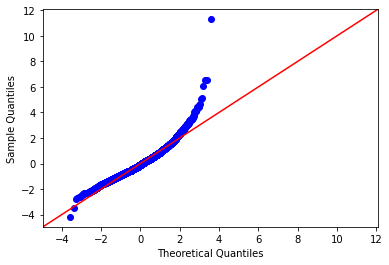

In [67]:
sm.qqplot(np.exp(model.resid),fit=True,line='45')

In [66]:
np.var(model.predict())/np.var(Mulit_df['Log_Price'])

0.9044162091683253